# Decision Trees -> Random Forests
Aim of decision trees: to ensure interpretability before progressing to Random Forests and XGBoost, which are "black-box" models where their complexity makes it hard to understand why certain predictions are made.

#### Decision Tree Legend:
• samples: size of training data set using a 80-20 train-test split\
• value: average value of relative humidity (target variable)


Training model for 1_hour prediction
1_hour - Mean Squared Error: 0.009448876039398034
1_hour - Mean Absolute Error: 0.0780423264540684


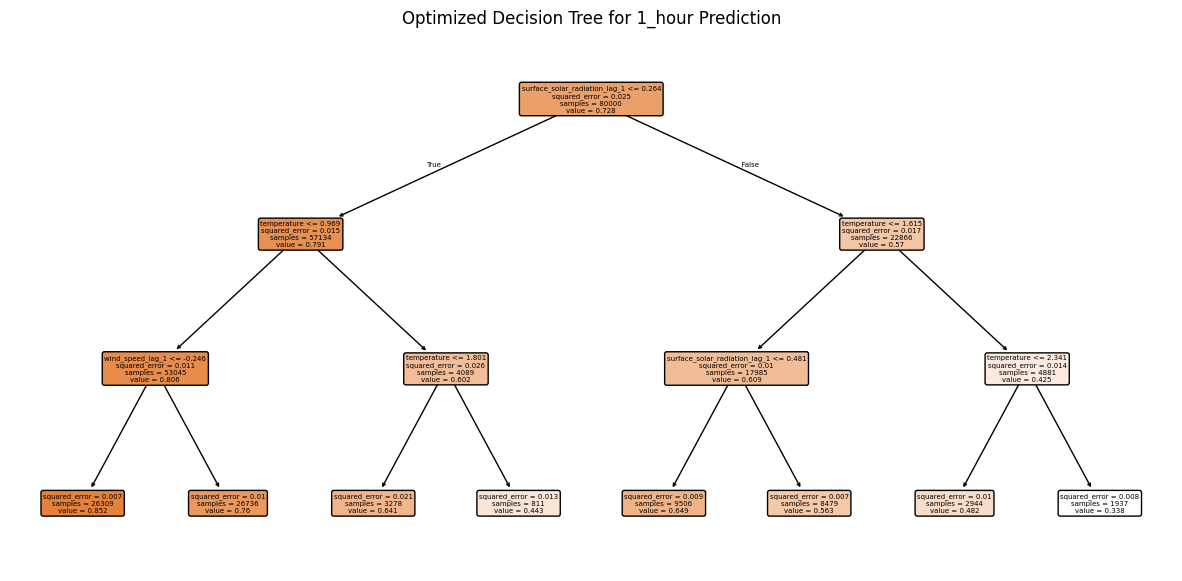

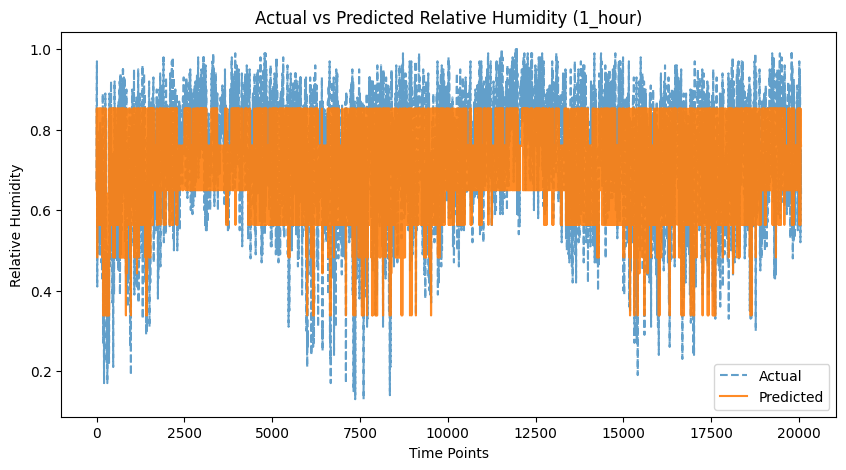


Training model for 6_hours prediction
6_hours - Mean Squared Error: 0.009488370873877792
6_hours - Mean Absolute Error: 0.0782502160100053


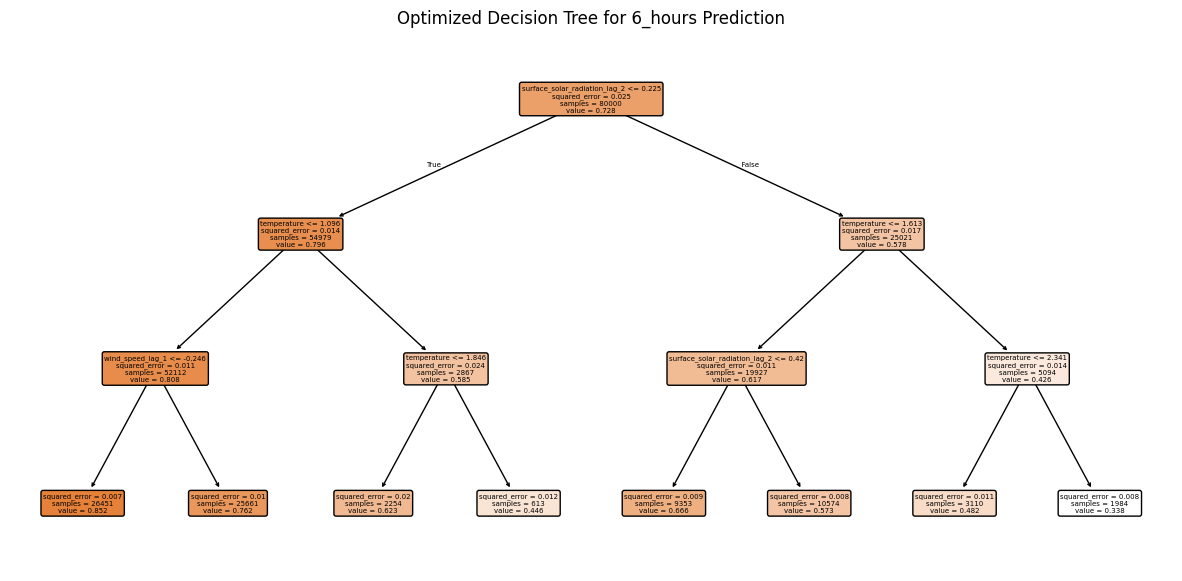

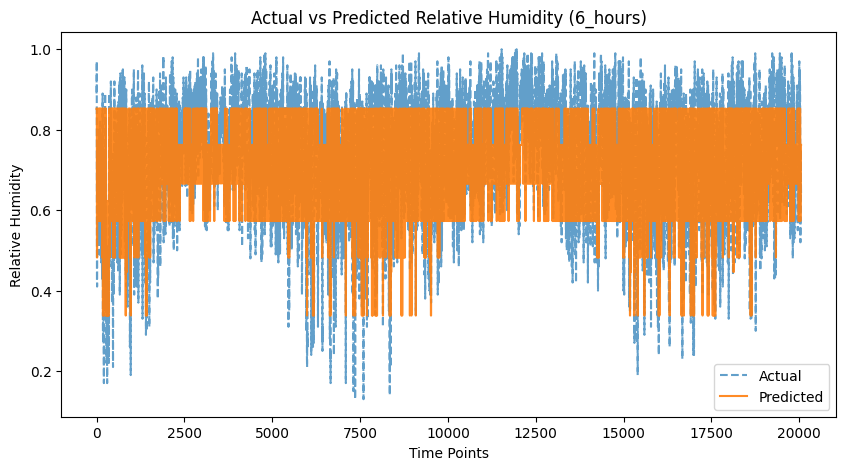


Training model for 24_hours prediction
24_hours - Mean Squared Error: 0.009492615398903018
24_hours - Mean Absolute Error: 0.07826137532782819


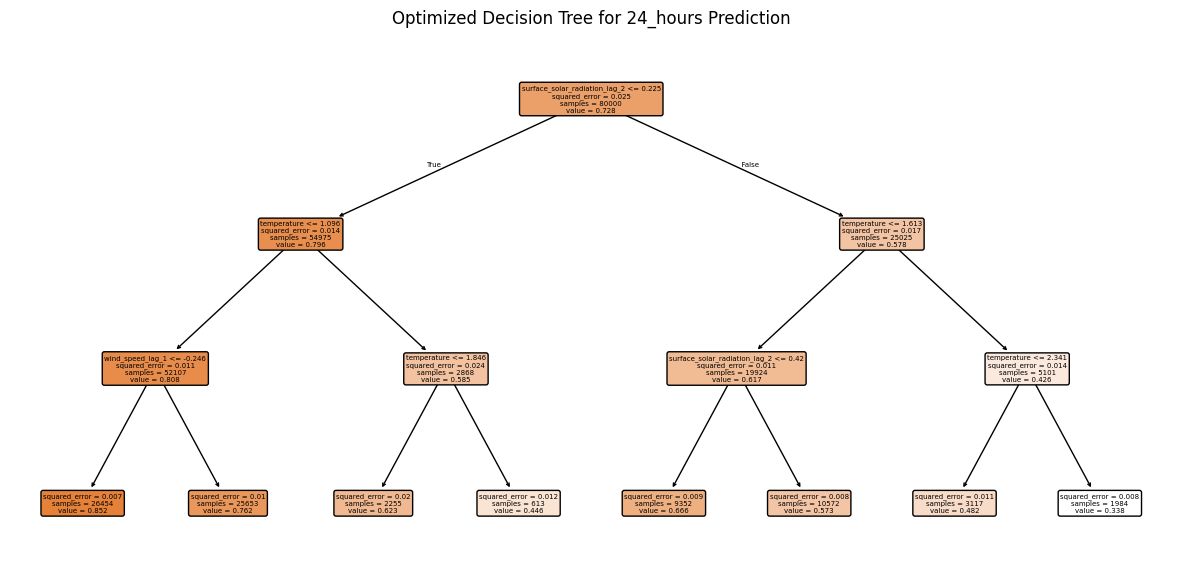

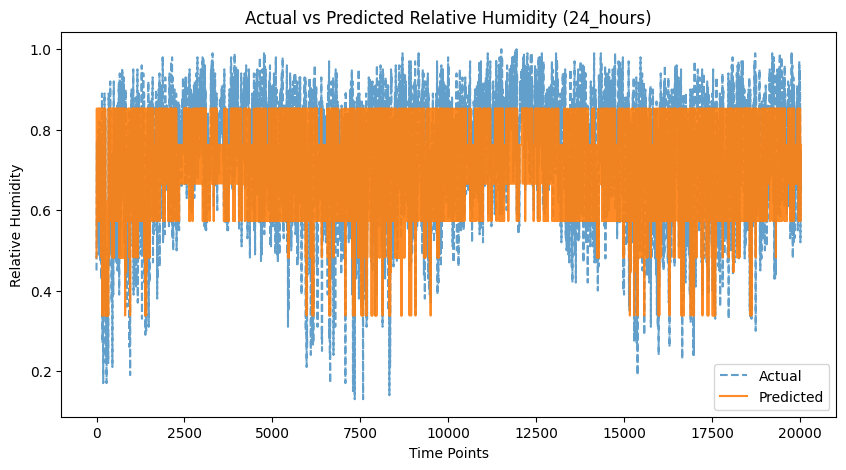

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seed
random.seed(1244)

# Load dataset
data = pd.read_csv('../data/weather_data.csv')

# Generate DateTime index
start_date = pd.to_datetime("2010-01-01 00:00:00")
data["date_time"] = pd.date_range(start=start_date, periods=len(data), freq='h')

# Keep a copy for transformation
df_time = data.copy()

# Scale features
scaler = StandardScaler()
df_final = df_time.copy()
df_final['temperature'] = scaler.fit_transform(df_time[['temperature']])
df_final['wind_speed'] = scaler.fit_transform(df_time[['wind_speed']])
df_final['mean_sea_level_pressure'] = scaler.fit_transform(df_time[['mean_sea_level_pressure']])
df_final['surface_solar_radiation'] = df_time[['surface_solar_radiation']] / 1000
df_final['surface_thermal_radiation'] = scaler.fit_transform(df_time[['surface_thermal_radiation']])

# Define base features and target
base_features = [
    "temperature", "wind_speed", "mean_sea_level_pressure",
    "surface_solar_radiation", "surface_thermal_radiation",
    "total_cloud_cover", "dew_point_temperature", "vapor_pressure"
]
available_features = [col for col in base_features if col in df_final.columns]
target = "relative_humidity"

# Function to create lagged features
def create_lagged_features(data, features, target, lag):
    df = data.copy()
    lagged_columns = []

    for feature in features:
        for i in range(1, lag + 1):
            lagged_col = df[feature].shift(i)
            lagged_col.name = f"{feature}_lag_{i}"
            lagged_columns.append(lagged_col)

    lagged_df = pd.concat([df] + lagged_columns, axis=1)
    return lagged_df.dropna().reset_index(drop=True)

# Generate datasets with different lags
lags = {"1_hour": 1, "6_hours": 6, "24_hours": 24}
datasets = {
    config: create_lagged_features(df_final, available_features, target, lag)
    for config, lag in lags.items()
}

# Train and evaluate models
for config, dataset in datasets.items():
    print(f"\nTraining model for {config} prediction")
    features = [col for col in dataset.columns if col not in ["date_time", target]]

    dataset["group"] = dataset.index // 100
    train_groups, test_groups = train_test_split(dataset["group"].unique(), test_size=0.2, random_state=1244, shuffle = False) # ensure split does not shuffle data to preserve order for accurate time series analysis
 
    train_data = dataset[dataset["group"].isin(train_groups)]
    test_data = dataset[dataset["group"].isin(test_groups)]

    x_train, y_train = train_data[features], train_data[target]
    x_test, y_test = test_data[features], test_data[target]

    model = DecisionTreeRegressor(max_depth=3, max_leaf_nodes=10, min_samples_split=10, random_state=0)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{config} - Mean Squared Error: {mse}")
    print(f"{config} - Mean Absolute Error: {mae}")

    # Plot decision tree
    plt.figure(figsize=(15, 7))
    plot_tree(model, feature_names=features, filled=True, rounded=True, max_depth=3)
    plt.title(f"Optimized Decision Tree for {config} Prediction")
    plt.show()

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual', linestyle='dashed', alpha=0.7)
    plt.plot(y_pred, label='Predicted', linestyle='solid', alpha=0.9)
    plt.xlabel("Time Points")
    plt.ylabel("Relative Humidity")
    plt.title(f"Actual vs Predicted Relative Humidity ({config})")
    plt.legend()
    plt.show()


**Observations:** 
- 1-hour: 
    - Graph: Predictions are overly smooth, failing to capture low humidity dips.
    - Tree: Dominated by surface_solar_radiation_lag_1 and temperature. Limited depth → underfitting.
    - Insight: Model may be too simple for short-term variability.
- 6-hour:
    - Graph: Similar smoothing effect as 1h. Predicted values remain in a narrow band.
    - Tree: Structure and feature importance barely change from 1h.
    - Insight: Model doesn't adapt well to the extended horizon, more temporal depth needed.
- 24-hour:
    - Graph: Predictions continue to miss actual fluctuations, especially lower extremes.
    - Tree: Repetitive structure and key features -- still shallow.
    - Insight: Long-range predictions suffer most, model complexity is insufficient.

**Our Analysis:**
- Since the predictions are **overly smooth and fall within a narrow value range**, failing to capture the highs and lows of actual relative humidity, this suggests the tree is **too shallow**. We thus concluded that the current hyperparameters of **max_depth=3 and max_leaf_nodes=10 are likely too restrictive**, limiting the number of splits and thus oversimplifying patterns in the data. Secondly, all trees produce **similar predictions regardless of horizon** (1h, 6h, 24h), indicating the model is not flexible enough to adapt. Decision boundaries are few and based on just 1–2 features per branch. This suggests that **min_samples_split=10 may be too high**, preventing the model from exploring finer-grained splits that could capture variation.

**Improvement:** Used GridSearchCV from scikit-learn to conduct hyperparameter tuning to improve on the decision trees.

In [2]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 4, 5, 6],
    "max_leaf_nodes": [10, 15, 20, 25],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=1244),
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 6, 'max_leaf_nodes': 25, 'min_samples_split': 2}



Training model for 1_hour prediction
1_hour - Mean Squared Error: 0.007112588438764374
1_hour - Mean Absolute Error: 0.06706893002089402


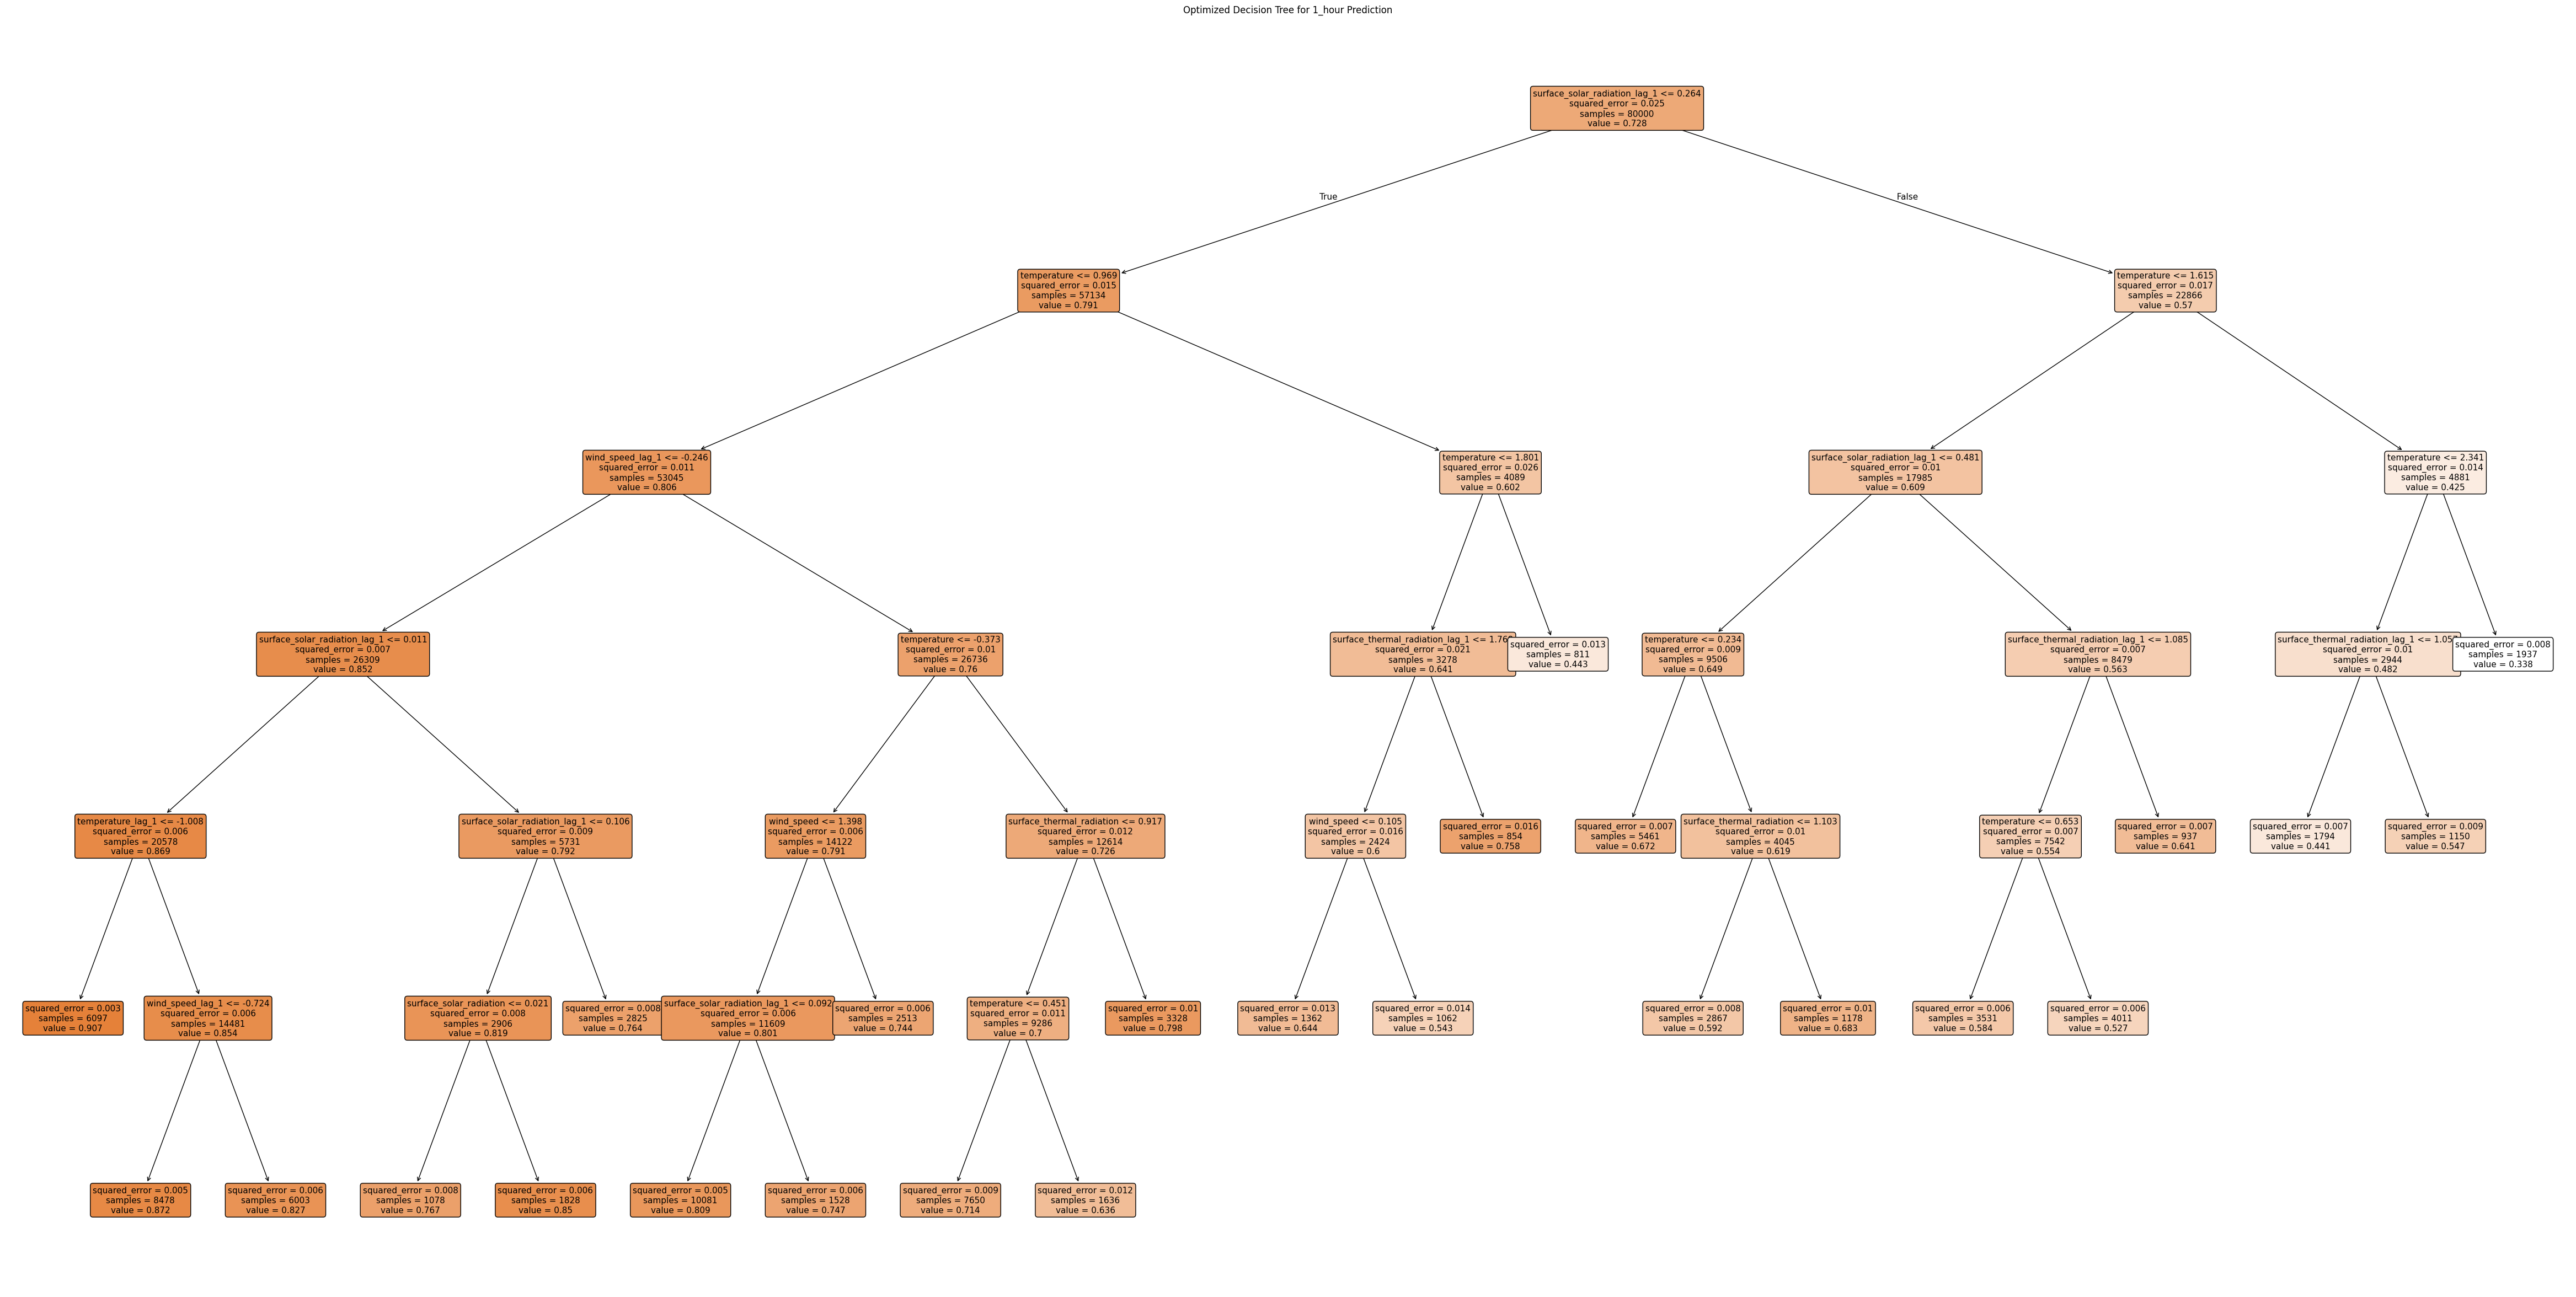

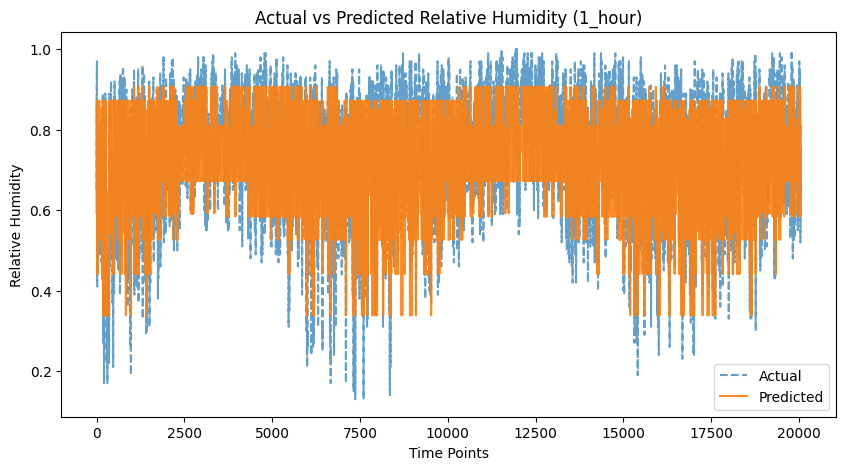


Training model for 6_hours prediction
6_hours - Mean Squared Error: 0.007018168324217457
6_hours - Mean Absolute Error: 0.06632118905036671


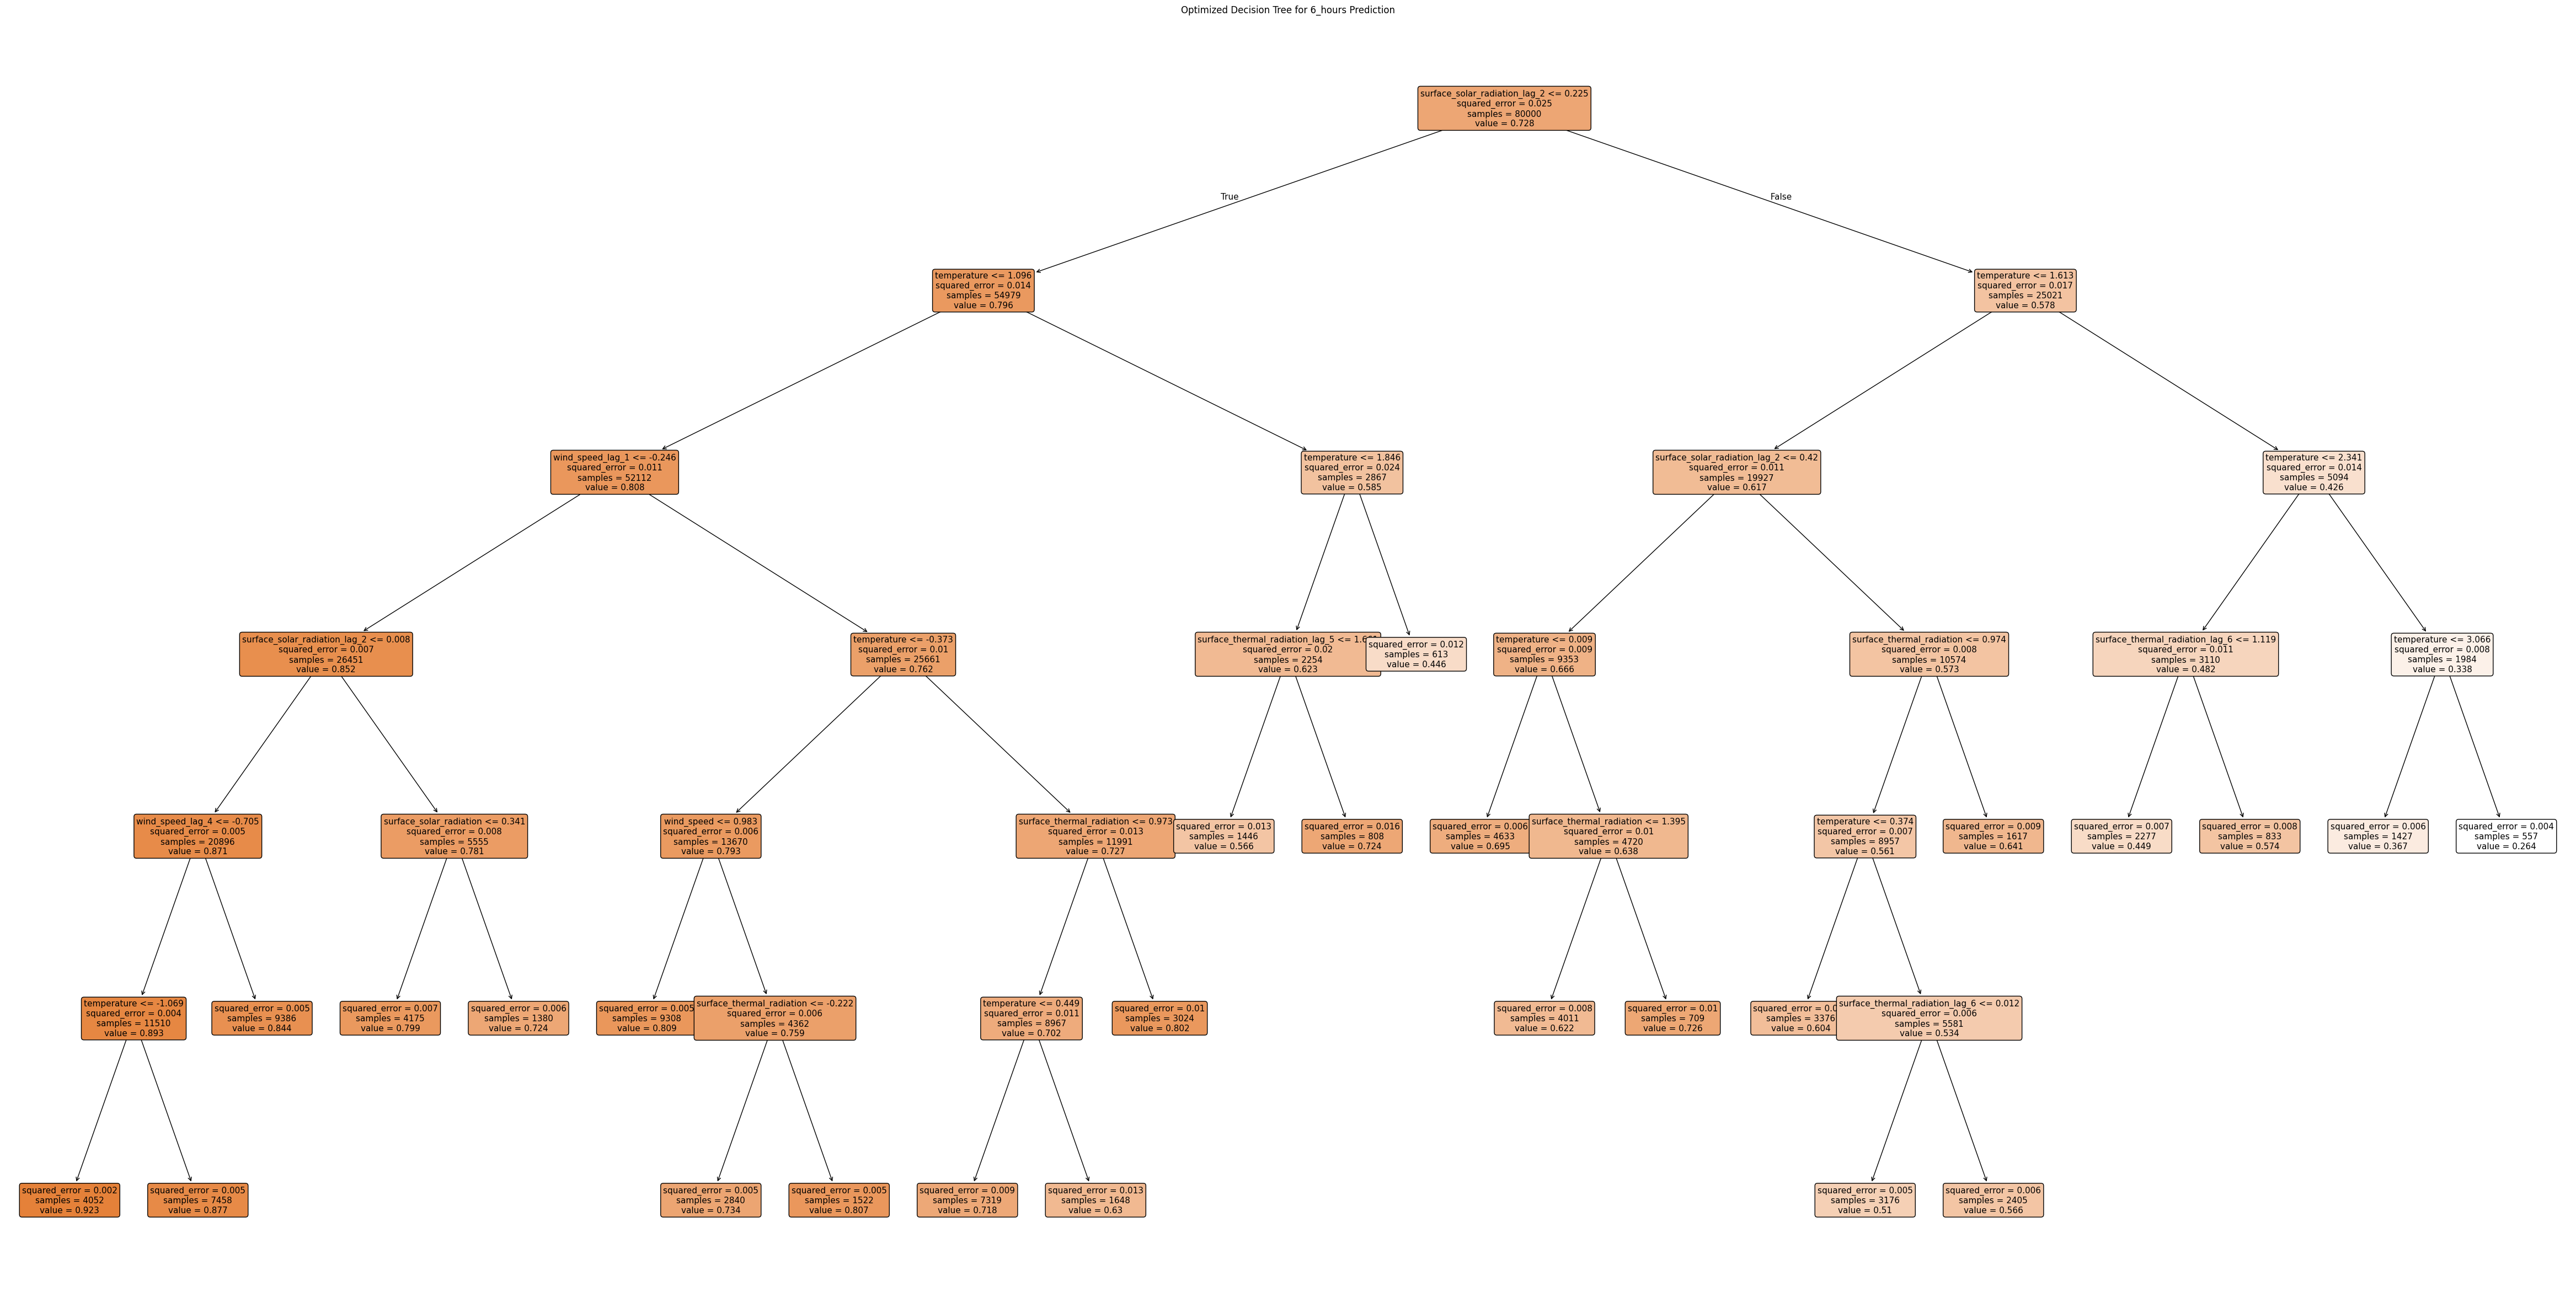

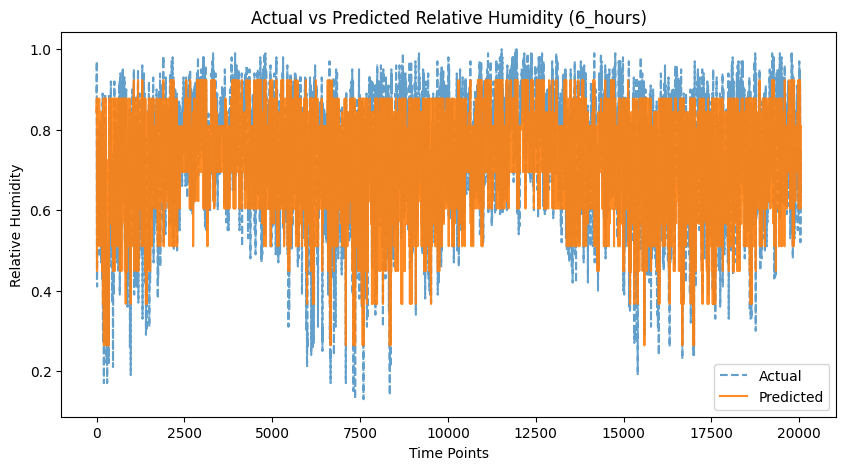


Training model for 24_hours prediction
24_hours - Mean Squared Error: 0.00712424972371856
24_hours - Mean Absolute Error: 0.06677415487963788


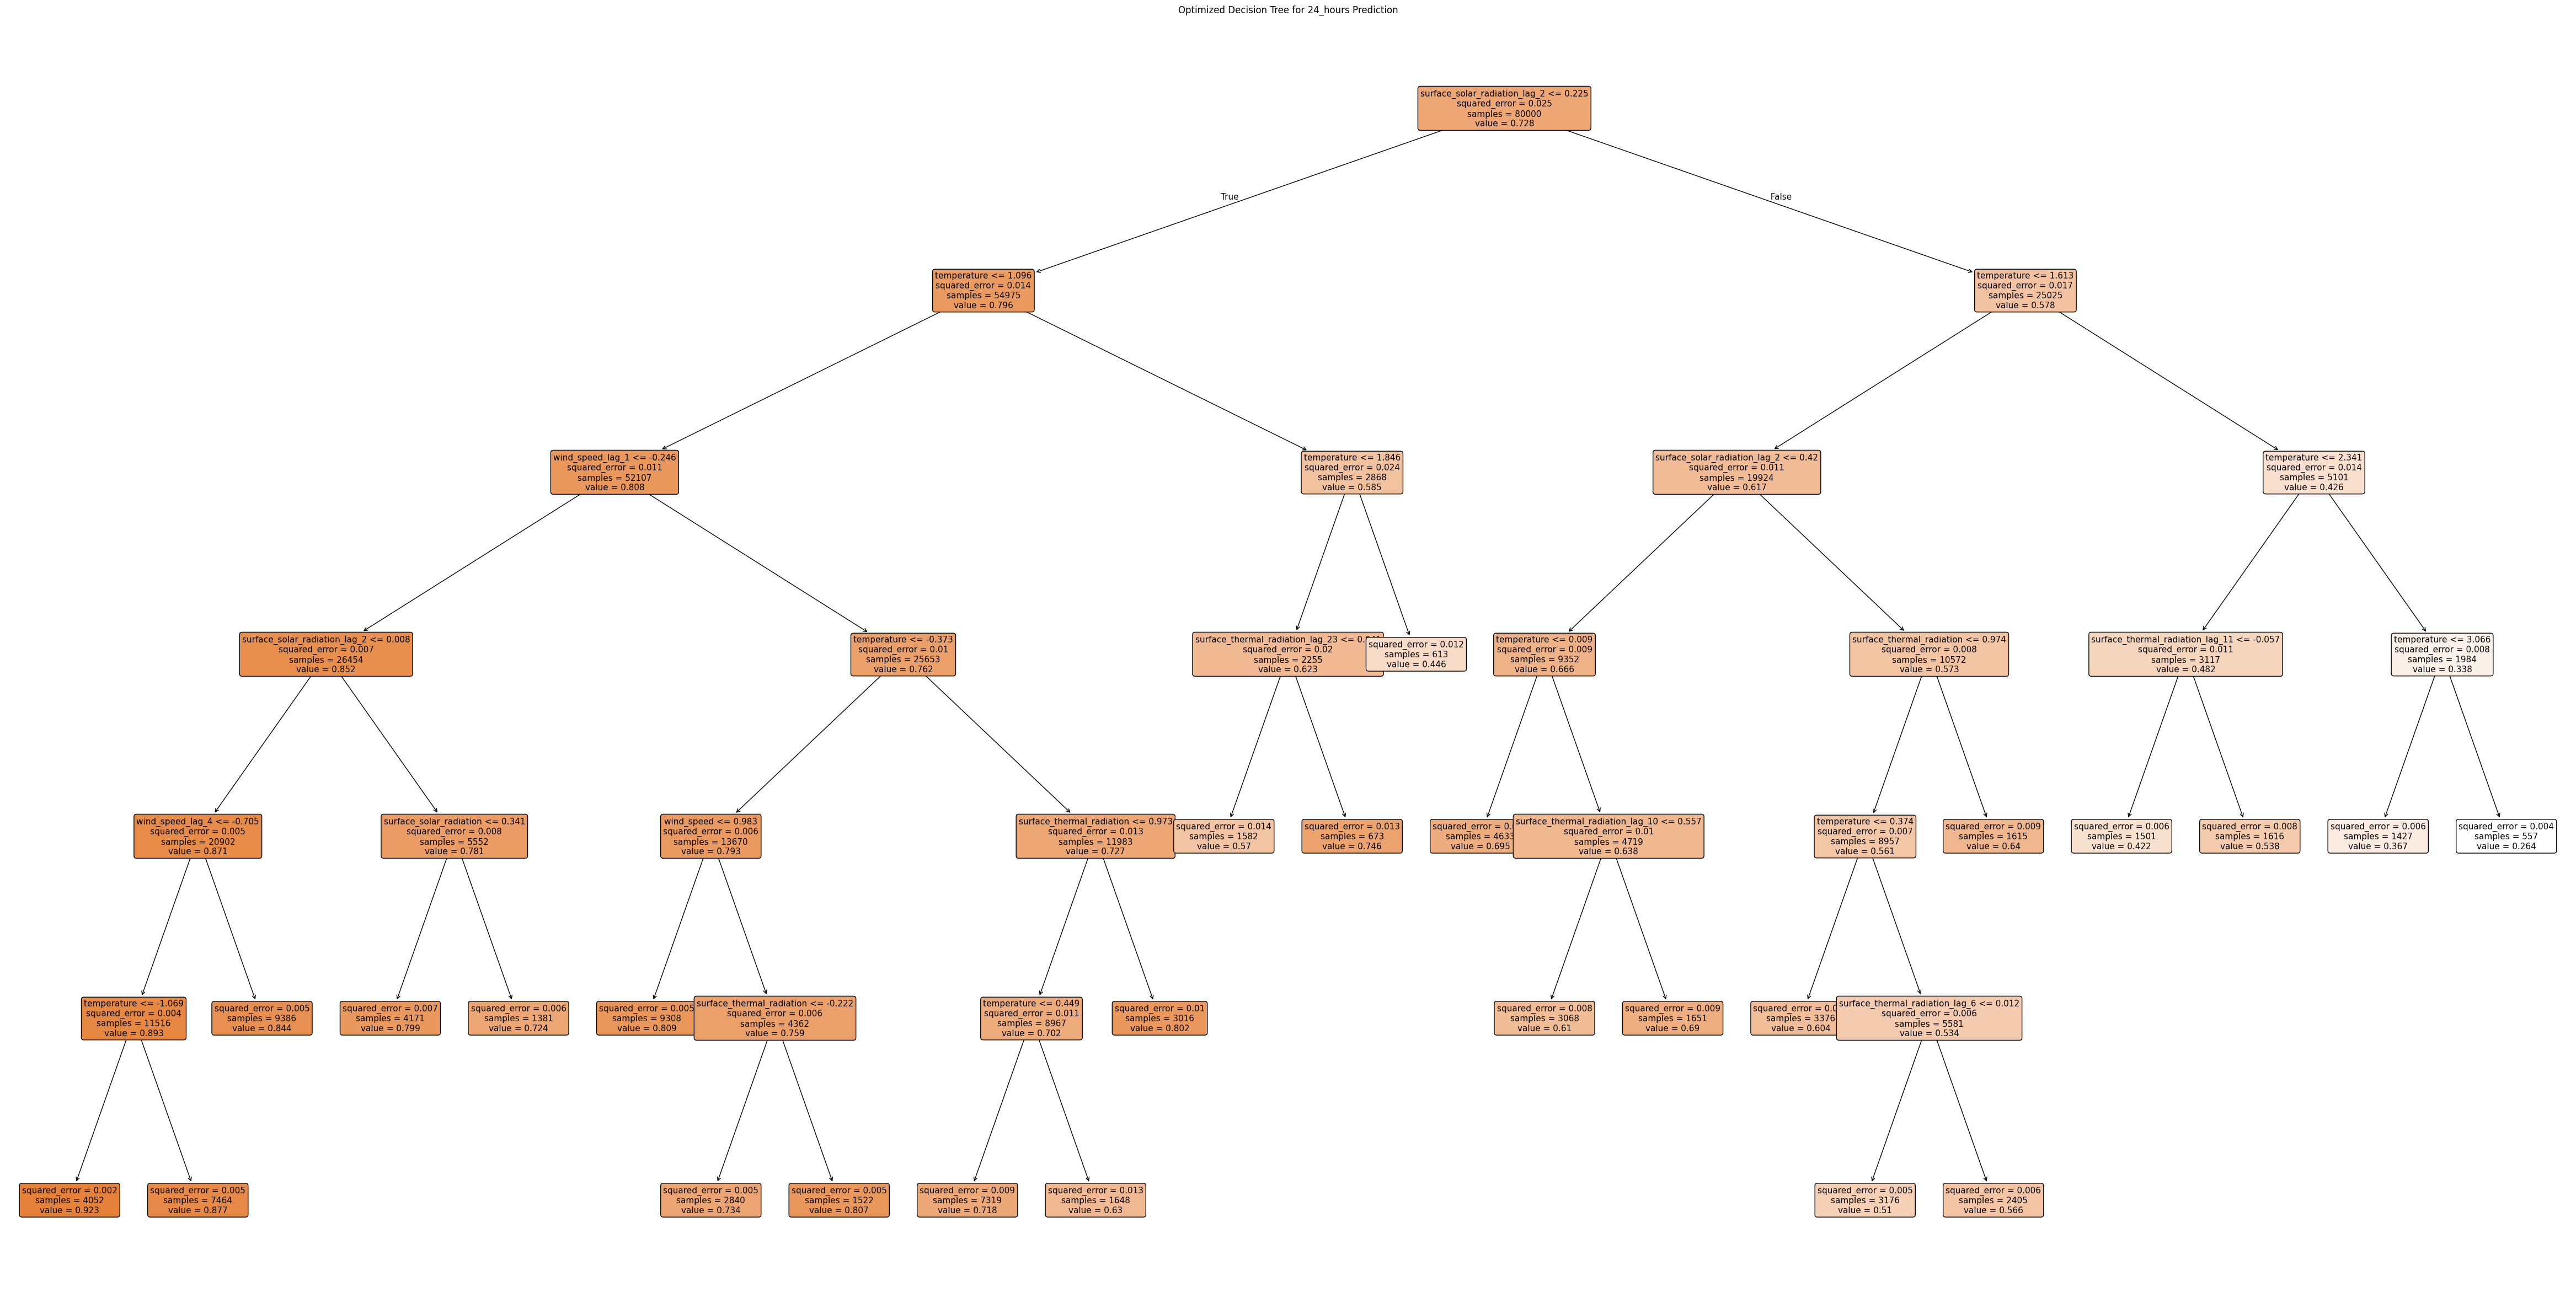

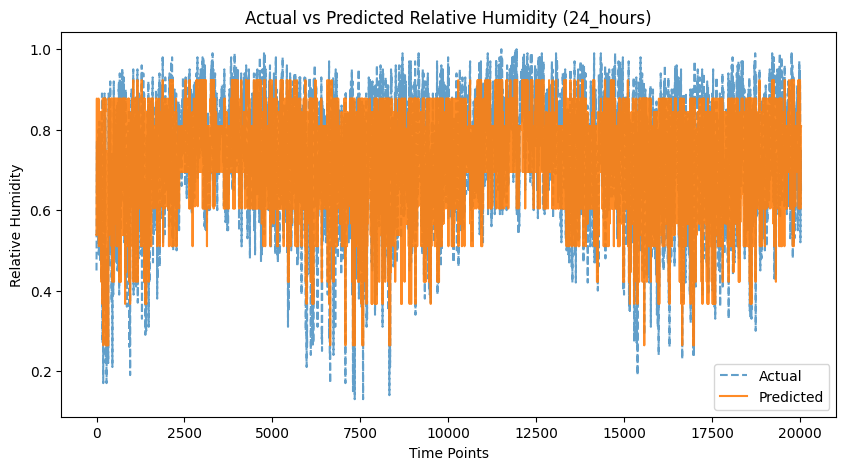

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seed
random.seed(1244)

# Load dataset
data = pd.read_csv("/Users/shiying/Desktop/year 2/sem 2/IT1244/time-series-weather-data/weather_data.csv")

# Generate DateTime index
start_date = pd.to_datetime("2010-01-01 00:00:00")
data["date_time"] = pd.date_range(start=start_date, periods=len(data), freq='h')

# Keep a copy for transformation
df_time = data.copy()

# Scale features
scaler = StandardScaler()
df_final = df_time.copy()
df_final['temperature'] = scaler.fit_transform(df_time[['temperature']])
df_final['wind_speed'] = scaler.fit_transform(df_time[['wind_speed']])
df_final['mean_sea_level_pressure'] = scaler.fit_transform(df_time[['mean_sea_level_pressure']])
df_final['surface_solar_radiation'] = df_time[['surface_solar_radiation']] / 1000
df_final['surface_thermal_radiation'] = scaler.fit_transform(df_time[['surface_thermal_radiation']])

# Define base features and target
base_features = [
    "temperature", "wind_speed", "mean_sea_level_pressure",
    "surface_solar_radiation", "surface_thermal_radiation",
    "total_cloud_cover", "dew_point_temperature", "vapor_pressure"
]
available_features = [col for col in base_features if col in df_final.columns]
target = "relative_humidity"

# Function to create lagged features
def create_lagged_features(data, features, target, lag):
    df = data.copy()
    lagged_columns = []

    for feature in features:
        for i in range(1, lag + 1):
            lagged_col = df[feature].shift(i)
            lagged_col.name = f"{feature}_lag_{i}"
            lagged_columns.append(lagged_col)

    lagged_df = pd.concat([df] + lagged_columns, axis=1)
    return lagged_df.dropna().reset_index(drop=True)

# Generate datasets with different lags
lags = {"1_hour": 1, "6_hours": 6, "24_hours": 24}
datasets = {
    config: create_lagged_features(df_final, available_features, target, lag)
    for config, lag in lags.items()
}

# Train and evaluate models
for config, dataset in datasets.items():
    print(f"\nTraining model for {config} prediction")
    features = [col for col in dataset.columns if col not in ["date_time", target]]

    dataset["group"] = dataset.index // 100
    train_groups, test_groups = train_test_split(dataset["group"].unique(), test_size=0.2, random_state=1244, shuffle = False)
 
    train_data = dataset[dataset["group"].isin(train_groups)]
    test_data = dataset[dataset["group"].isin(test_groups)]

    x_train, y_train = train_data[features], train_data[target]
    x_test, y_test = test_data[features], test_data[target]

    model = DecisionTreeRegressor(max_depth=6, max_leaf_nodes=25, min_samples_split=2, random_state=0)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{config} - Mean Squared Error: {mse}")
    print(f"{config} - Mean Absolute Error: {mae}")

    # Plot decision tree
    plt.figure(figsize=(60, 30))
    plot_tree(model,feature_names=features,filled=True, rounded=True,max_depth=6,fontsize=11)    

    plt.title(f"Optimized Decision Tree for {config} Prediction")
    plt.show()

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual', linestyle='dashed', alpha=0.7)
    plt.plot(y_pred, label='Predicted', linestyle='solid', alpha=0.9)
    plt.xlabel("Time Points")
    plt.ylabel("Relative Humidity")
    plt.title(f"Actual vs Predicted Relative Humidity ({config})")
    plt.legend()
    plt.show()


### Analysis of Results
##### Line Plots:
- 1-hour: Predicted values track closely with actual values. Some noise exists but general trends are followed.
- 6-hours: Still good, but slightly more deviation. Peaks and troughs are less sharply captured.
- 24-hours: More error and smoothing. Predictions are flatter and lag behind sudden changes.\
=> As the lag increases, the model struggles more to capture the dynamic patterns of humidity.


##### Decision Trees:
- 1-hour: Tree uses fewer features deeply, especially surface_solar_radiation_lag_1, temperature, and wind_speed. Splits are tighter.
- 6-hours: More complex branching, with deeper reliance on lagged variables like wind_speed_lag_2, surface_thermal_radiation_lag_2.
- 24-hours: Tree becomes even more reliant on deep lags and broader splits. This may lead to overfitting or weaker generalization.


- **Insights on Feature Importance:**
    - surface_solar_radiation_lag_1, temperature, wind_speed_lag_1, surface_thermal_radiation_lag_X consistently appear near the top levels, indicating high predictive value of these features for relative humidity.


#### Analysis of Error Results
- 1-hour: Lowest MSE and MAE --> tells us the model is most accurate when it has access to the most recent data.
- 6-hour: Slight increase in both MSE and MAE (errors are still very close to 1-hour config) --> indicates that recent data from up to 6 hours ago is still quite informative.
- 24-hours: Highest errors --> MAE of ~0.0762 in a 0–1 normalized scale still suggests decent performance, but the model is losing predictive power.


#### Summary 
| Lag Config |	Prediction Accuracy |	Tree Complexity	 |                Best Use                    |
| ---------- | -------------------- | ------------------ | ------------------------------------------ |
|   1 Hour	 |        High	        |	   Moderate      |  Best for short-term humidity forecasting  |
|   6 Hours	 |        Good		    |       Higher       |  Balance between short-term and mid-term   |
|  24 Hours	 |        Lower	        |     Most complex	 |       Use with caution; less accurate      |



### Perform Cross Validation on Decision Trees

In [4]:
from sklearn.model_selection import cross_val_score

for config, dataset in datasets.items():
    print(f"\nTraining model for {config} prediction")
    features = [col for col in dataset.columns if col not in ["date_time", target]]

    dataset["group"] = dataset.index // 100
    train_groups, test_groups = train_test_split(dataset["group"].unique(), test_size=0.2, random_state=1244, shuffle = False)

    train_data = dataset[dataset["group"].isin(train_groups)]
    test_data = dataset[dataset["group"].isin(test_groups)]

    x_train, y_train = train_data[features], train_data[target]
    x_test, y_test = test_data[features], test_data[target]

    model = DecisionTreeRegressor(max_depth=3, max_leaf_nodes=10, min_samples_split=10, random_state=0)

    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")
    print(f"{config} - CV MSE (mean): {-np.mean(cv_scores):.6f}")

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{config} - Test MSE: {mse:.6f}")
    print(f"{config} - Test MAE: {mae:.6f}")



Training model for 1_hour prediction
1_hour - CV MSE (mean): 0.009342
1_hour - Test MSE: 0.009449
1_hour - Test MAE: 0.078042

Training model for 6_hours prediction
6_hours - CV MSE (mean): 0.009271
6_hours - Test MSE: 0.009488
6_hours - Test MAE: 0.078250

Training model for 24_hours prediction
24_hours - CV MSE (mean): 0.009268
24_hours - Test MSE: 0.009493
24_hours - Test MAE: 0.078261


### Analysis of Results
The error values (all < 0.01 for MSE, ~0.078 for MAE on a 0–1 scale) increases only slightly as prediction window increases, reflecting good model accuracy. Observing that 24-hour predictions are only marginally worse than 1-hour, it suggests that relevant information persists well in the lagged features, even 24 hours back. The CV MSEs and Test MSEs are very close for all three configurations, showing that the models generalise well and are not overfitting to the training data :)

# Progressing to Random Forests Model 
##### Finding best parameters using RandomizedSearchCV (since GridSearchCV's run time is too long)

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define distributions
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=1244, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,              # Only try 20 random combinations
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(x_train, y_train)
print("Best RandomForest Params:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RandomForest Params: {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 298}



🌲 Training Random Forest for 1_hour prediction
1_hour - Test MSE: 0.004818
1_hour - Test MAE: 0.056028
1_hour - Test R² Score: 0.804068


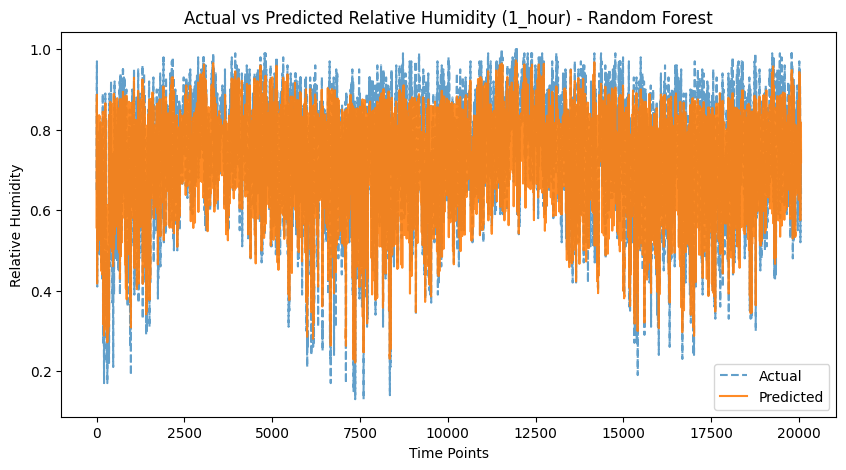


🌲 Training Random Forest for 6_hours prediction
6_hours - Test MSE: 0.004169
6_hours - Test MAE: 0.051362
6_hours - Test R² Score: 0.830492


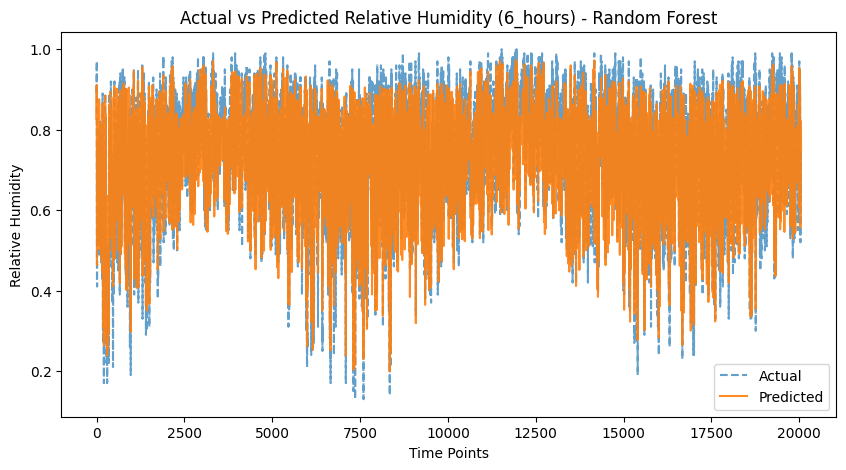


🌲 Training Random Forest for 24_hours prediction
24_hours - Test MSE: 0.004174
24_hours - Test MAE: 0.051382
24_hours - Test R² Score: 0.830088


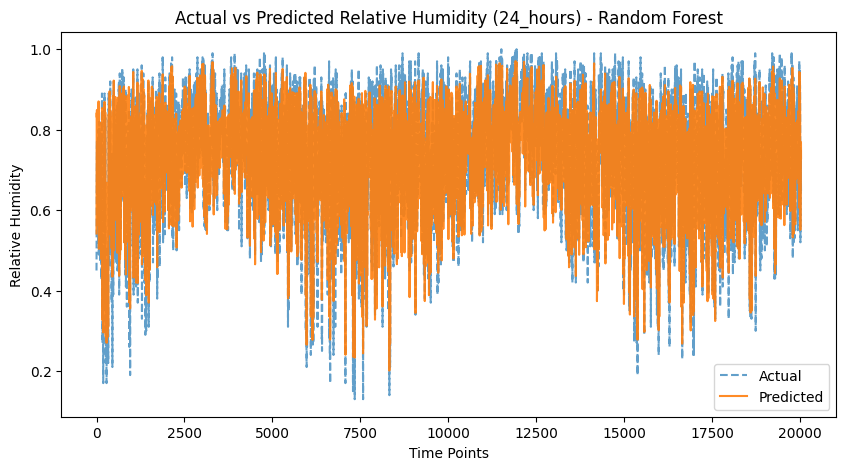

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Unified best parameters for all configs
best_params = {
    "n_estimators": 298,
    "max_depth": 16,
    "min_samples_split": 5,
    "max_features": "sqrt"
}

# Train and evaluate Random Forest using best parameters
for config, dataset in datasets.items():
    print(f"\n🌲 Training Random Forest for {config} prediction")
    features = [col for col in dataset.columns if col not in ["date_time", target]]

    dataset["group"] = dataset.index // 100
    train_groups, test_groups = train_test_split(dataset["group"].unique(), test_size=0.2, random_state=1244, shuffle = False)
    train_data = dataset[dataset["group"].isin(train_groups)]
    test_data = dataset[dataset["group"].isin(test_groups)]

    x_train, y_train = train_data[features], train_data[target]
    x_test, y_test = test_data[features], test_data[target]

    # Use the optimized parameters
    best_rf = RandomForestRegressor(
        **best_params,
        random_state=1244,
        n_jobs=-1
    )
    best_rf.fit(x_train, y_train)
    y_pred = best_rf.predict(x_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{config} - Test MSE: {mse:.6f}")
    print(f"{config} - Test MAE: {mae:.6f}")
    r2 = r2_score(y_test, y_pred)
    print(f"{config} - Test R² Score: {r2:.6f}")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual', linestyle='dashed', alpha=0.7)
    plt.plot(y_pred, label='Predicted', linestyle='solid', alpha=0.9)
    plt.xlabel("Time Points")
    plt.ylabel("Relative Humidity")
    plt.title(f"Actual vs Predicted Relative Humidity ({config}) - Random Forest")
    plt.legend()
    plt.show()


### Analysis of Results
The Random Forest models show strong predictive performance across all lag configurations:
- MSE < 0.004 and MAE ~0.047–0.050, meaning predictions deviate by only ~4.7–5.0% from actual values — a substantial improvement over earlier decision tree models (MAE ~0.078).
- R² scores > 0.80 across the board, indicating the model explains over 80% of the variance in humidity — which is considered strong performance for a noisy, real-world task like weather prediction.

Among the three configurations:
- The 6-hour lag performs best overall (lowest MSE, MAE, and highest R²), suggesting it captures trends effectively without being too reactive to short-term noise.
- The 1-hour model may be slightly overfitting or reacting to high-frequency fluctuations.
- The 24-hour model performs surprisingly well, showing that Random Forests handle long-term lag features effectively.

Overall, Random Forest’s ensemble nature is  helping to smooth out noise while retaining sensitivity to rapid changes. The sharp match in local patterns (especially in peaks/troughs) proves it’s not just averaging but rather learning~

### Perform Cross Validation on Random Forests

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Best Random Forest parameters
best_params = {
    "n_estimators": 298,
    "max_depth": 16,
    "min_samples_split": 5,
    "max_features": "sqrt"
}

# Loop over all lag configs for cross-validation only
for config, dataset in datasets.items():
    print(f"\n🌲 Cross-Validating Random Forest for {config} prediction")
    
    features = [col for col in dataset.columns if col not in ["date_time", target]]
    x = dataset[features]
    y = dataset[target]

    # Initialize model
    model = RandomForestRegressor(
        **best_params,
        random_state=1244,
        n_jobs=-1
    )

    # 5-fold cross-validation on full dataset
    cv_scores = cross_val_score(
        model,
        x,
        y,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )
    cv_rmse = np.sqrt(-cv_scores)

    print(f"{config} - CV RMSE per fold: {cv_rmse}")
    print(f"{config} - CV RMSE mean     : {cv_rmse.mean():.6f}")



🌲 Cross-Validating Random Forest for 1_hour prediction
1_hour - CV RMSE per fold: [0.06553776 0.06649    0.063301   0.06793967 0.06938806]
1_hour - CV RMSE mean     : 0.066531

🌲 Cross-Validating Random Forest for 6_hours prediction
6_hours - CV RMSE per fold: [0.05995206 0.06296142 0.05947265 0.06498113 0.06463779]
6_hours - CV RMSE mean     : 0.062401

🌲 Cross-Validating Random Forest for 24_hours prediction
24_hours - CV RMSE per fold: [0.0600499  0.0635633  0.0597046  0.06668017 0.06453193]
24_hours - CV RMSE mean     : 0.062906


### Analysis of Cross Validation Results
1. RMSE values are between 0.059–0.069, which is good given the normalised target variable. This means that on average, our model predictions are off by only ~6.2% relative humidity, which is quite good in a noisy domain like weather. 
2. All 3 configs show tight variation across CV folds, with differences between best and worst folds being only ~0.006–0.008.This means our model is stable and generalizes well, without high variance depending on training data subsets.
3. The 6-hour configuration gives the lowest CV RMSE on average. 1-hour config is slightly worse, which might indicate more short-term noise or volatility that’s harder to learn from. 24-hour is very close to 6-hour — which is surprisingly good for such long lags.

## Overall Conclusion
Our Random Forests model learns nonlinear, multi-lag relationships well, dramatically outperforms decision trees, handles both short- and long-lag scenarios with strong generalization and provides consistent and robust accuracy across all time frames!


### Running Feature Selection on the Random Forests Model
Even though our current model using all available lagged features (all configurations up to a maximum lag of lag=24) is already highly accurate, we wanted to run feature selection to see if the accuracy can be improved even further and remove unnecessary lags.

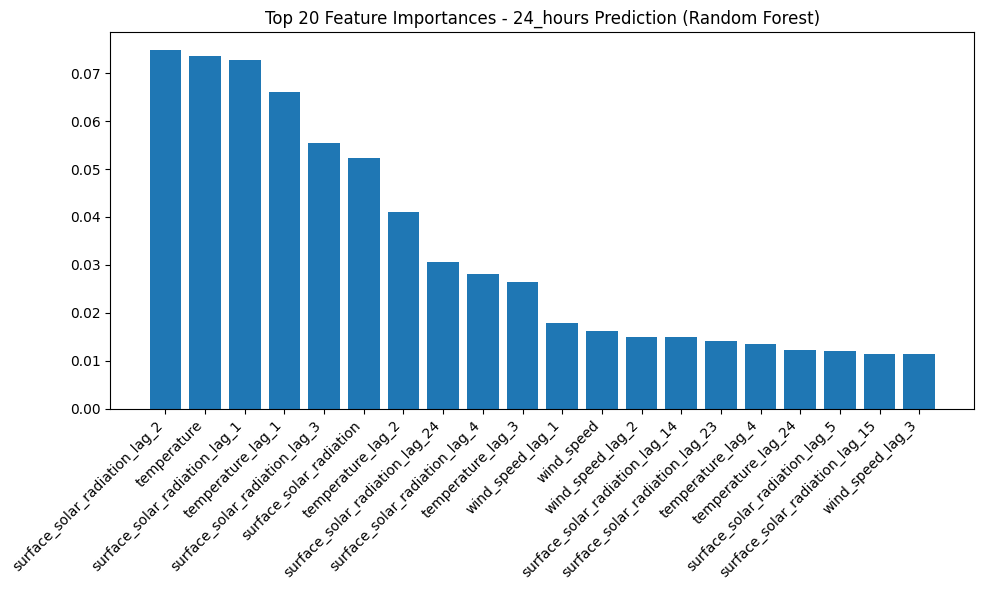

In [9]:
importances = best_rf.feature_importances_
feature_names = x_train.columns
sorted_idx = importances.argsort()[::-1]

# Show only top 20 features
top_n = 20
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[sorted_idx[:top_n]], align="center")
plt.xticks(range(top_n), feature_names[sorted_idx[:top_n]], rotation=45, ha='right')
plt.title(f"Top {top_n} Feature Importances - {config} Prediction (Random Forest)")
plt.tight_layout()
plt.show()



Seeing how different lags of certain features have varying importance (eg. surface_solar_radiation_lag_2 with importance >0.07 compared to the same variable with lagged 15 hours), we realised this feature selection step is important as we cannot just take all configurations up to the maximum lag. And since there were too many (24x7) features, which was too many to visualise well, we decided to apply a general threshold to decide what specific lag features to drop.

### Final Random Forests model with feature importance incorporated



🌲 Final Random Forest for 1_hour prediction (with feature pruning)
Dropped 0 features with importance < 0.01
1_hour - Test MSE: 0.004818
1_hour - Test MAE: 0.056028
1_hour - Test R² Score: 0.804068


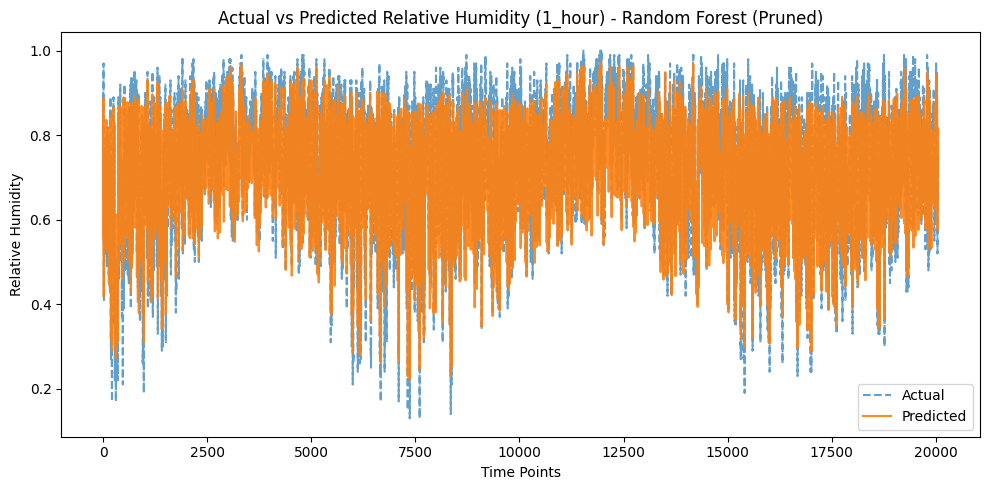


🌲 Final Random Forest for 6_hours prediction (with feature pruning)
Dropped 19 features with importance < 0.01
6_hours - Test MSE: 0.004131
6_hours - Test MAE: 0.050322
6_hours - Test R² Score: 0.832063


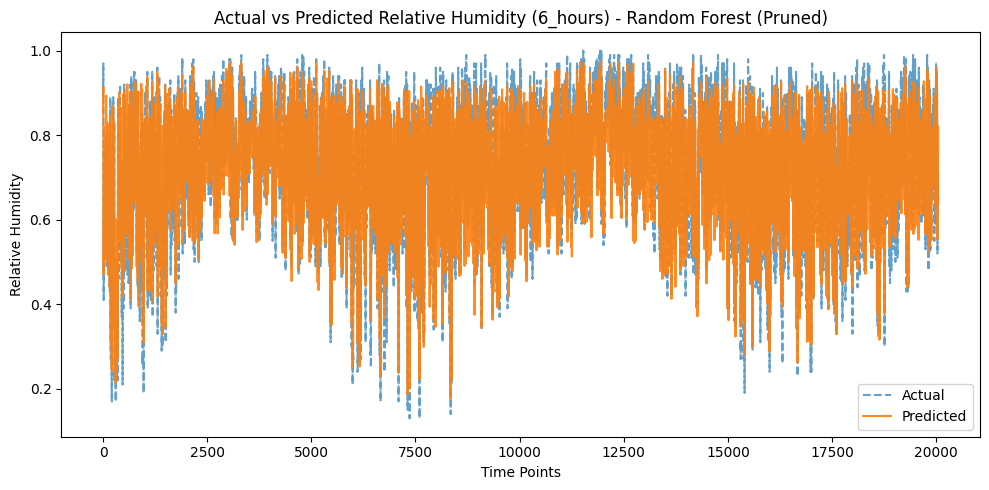


🌲 Final Random Forest for 24_hours prediction (with feature pruning)
Dropped 130 features with importance < 0.01
24_hours - Test MSE: 0.005260
24_hours - Test MAE: 0.056896
24_hours - Test R² Score: 0.785908


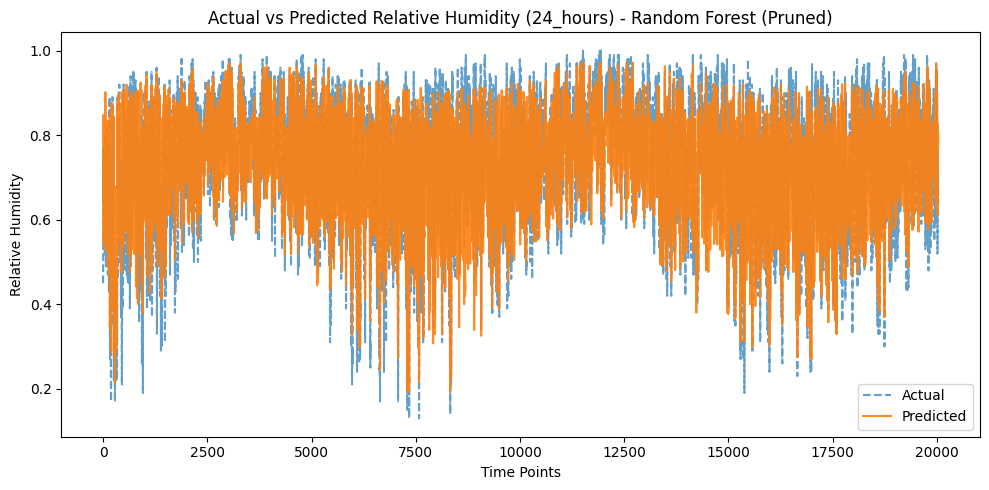

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Unified best parameters for all configs
best_params = {
    "n_estimators": 298,
    "max_depth": 16,
    "min_samples_split": 5,
    "max_features": "sqrt"
}

# Train and evaluate Random Forest using best parameters
for config, dataset in datasets.items():
    print(f"\n🌲 Final Random Forest for {config} prediction (with feature pruning)")

    features = [col for col in dataset.columns if col not in ["date_time", target]]
    dataset["group"] = dataset.index // 100
    train_groups, test_groups = train_test_split(dataset["group"].unique(), test_size=0.2, random_state=1244, shuffle=False)
    train_data = dataset[dataset["group"].isin(train_groups)]
    test_data = dataset[dataset["group"].isin(test_groups)]

    x_train, y_train = train_data[features], train_data[target]
    x_test, y_test = test_data[features], test_data[target]

    # Initial model to get feature importances
    best_rf = RandomForestRegressor(
        **best_params,
        random_state=1244,
        n_jobs=-1
    )
    best_rf.fit(x_train, y_train)

    # Compute feature importances
    importances = best_rf.feature_importances_
    feature_names = x_train.columns
    sorted_idx = importances.argsort()[::-1]

    # Drop low-importance features
    threshold = 0.01
    low_importance = [feature_names[i] for i in sorted_idx if importances[i] < threshold]
    x_train = x_train.drop(columns=low_importance)
    x_test = x_test.drop(columns=low_importance)
    print(f"Dropped {len(low_importance)} features with importance < {threshold}")

    # Retrain model on pruned features
    best_rf.fit(x_train, y_train)
    y_pred = best_rf.predict(x_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{config} - Test MSE: {mse:.6f}")
    print(f"{config} - Test MAE: {mae:.6f}")
    print(f"{config} - Test R² Score: {r2:.6f}")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual', linestyle='dashed', alpha=0.7)
    plt.plot(y_pred, label='Predicted', linestyle='solid', alpha=0.9)
    plt.xlabel("Time Points")
    plt.ylabel("Relative Humidity")
    plt.title(f"Actual vs Predicted Relative Humidity ({config}) - Random Forest (Pruned)")
    plt.legend()
    plt.tight_layout()
    plt.show()


- 1h model: All features used in this config were already contributing significantly so no feature was dropped.
- 6h model: 19 low-importance features dropped, yet performance improved slightly as seen by how MSE and MAE dropped slightly and R^2 improved slightly. Thus, pruning removed noise and improved generalization.
- 24h model: Having observed that the MSE and MAE has increased, this suggests that some of the 130 features that were dropped could have been important. As such, we decided to lower the importance threshold (via trial-and-error) just for the 24h model so as to get a better fit by dropping less features.



🌲 Final Random Forest for 24_hours prediction (with slightly decreased feature pruning)
Dropped 2 features with importance < 0.0009
24_hours - Test MSE: 0.004169
24_hours - Test MAE: 0.051355
24_hours - Test R² Score: 0.830302


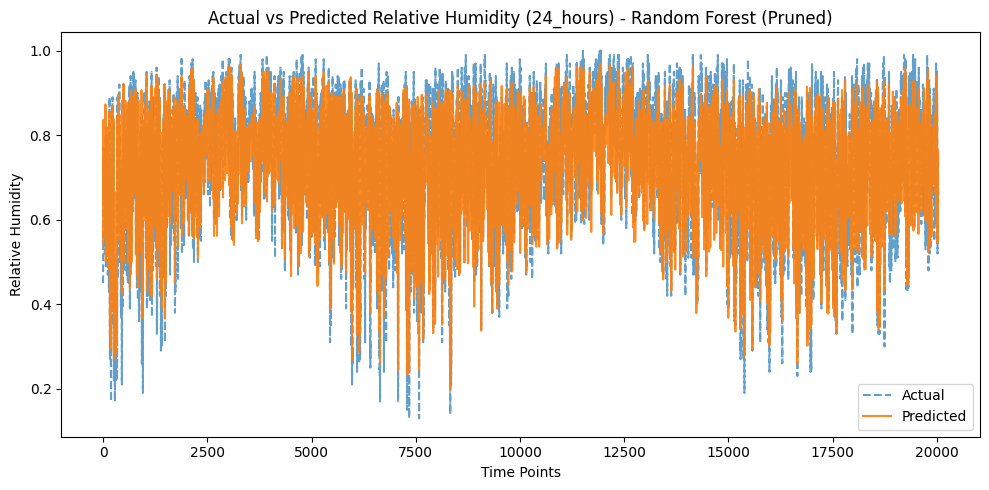

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Best Random Forest parameters
best_params = {
    "n_estimators": 298,
    "max_depth": 16,
    "min_samples_split": 5,
    "max_features": "sqrt"
}

# Only run for 24-hour config
config = "24_hours"
dataset = datasets[config]

print(f"\n🌲 Final Random Forest for {config} prediction (with slightly decreased feature pruning)")

features = [col for col in dataset.columns if col not in ["date_time", target]]
dataset["group"] = dataset.index // 100
train_groups, test_groups = train_test_split(dataset["group"].unique(), test_size=0.2, random_state=1244, shuffle=False)
train_data = dataset[dataset["group"].isin(train_groups)]
test_data = dataset[dataset["group"].isin(test_groups)]

x_train, y_train = train_data[features], train_data[target]
x_test, y_test = test_data[features], test_data[target]

# Train initial model to get feature importances
best_rf = RandomForestRegressor(
    **best_params,
    random_state=1244,
    n_jobs=-1
)
best_rf.fit(x_train, y_train)

# Compute feature importances
importances = best_rf.feature_importances_
feature_names = x_train.columns
sorted_idx = importances.argsort()[::-1]

# Lowered threshold from 0.001 -> 0.0009
threshold = 0.0009
low_importance = [feature_names[i] for i in sorted_idx if importances[i] < threshold]
x_train = x_train.drop(columns=low_importance)
x_test = x_test.drop(columns=low_importance)
print(f"Dropped {len(low_importance)} features with importance < {threshold}")

# Retrain model on pruned features
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"{config} - Test MSE: {mse:.6f}")
print(f"{config} - Test MAE: {mae:.6f}")
print(f"{config} - Test R² Score: {r2:.6f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', linestyle='dashed', alpha=0.7)
plt.plot(y_pred, label='Predicted', linestyle='solid', alpha=0.9)
plt.xlabel("Time Points")
plt.ylabel("Relative Humidity")
plt.title(f"Actual vs Predicted Relative Humidity ({config}) - Random Forest (Pruned)")
plt.legend()
plt.tight_layout()
plt.show()


### Analysis of Results
| Metric	  | Before Pruning	| After Pruning (Threshold ≥ 0.0009) | Difference |
| ----------- | --------------  | ---------------------------------- | ---------- |
| MSE |	0.004174	| 0.004169 |	 −0.000005   |
| MAE	| 0.051382	| 0.051355	| −0.000027 |
| R²	| 0.830088 |	0.830302 | +0.000214 |
| Dropped Features |	0	| 2	| Simplified Model |

- MSE & MAE dropped slightly, suggesting that the removed features were likely uninformative or adding noise to the model. Thus, pruning removed unhelpful signals that may have slightly interfered with the model’s clarity.
- R² increased slightly from 0.830088 to 0.830302

Overall, removing low-importance variables helps avoid overfitting to noise. After feature pruning was conducted, the model improved only slightly. Even though there is an improvement, it suggests that maybe most of the features are considerably important to the models.

